<a href="https://colab.research.google.com/github/parjhanya/Image_Classification/blob/master/CIFAR_10_Keras_Transfer_learning_Copy(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split

In [28]:
from keras import Sequential
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [4]:
#Import dataset
from keras.datasets import cifar10

In [5]:
#Divide the data in Train, Validation and Test Datasets
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [6]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [7]:
#Print the dimensions of the datasets
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [8]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [9]:
# Print the dimensions one more time
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [10]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 


In [11]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [12]:
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [13]:
#Build the model

#The first base model used is VGG19. The pretrained weights from the imagenet challenge are used
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])


80142336/80134624 [==============================] - 1s 0us/step


In [14]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers


In [15]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer


In [17]:
#Check final model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [18]:
batch_size= 32
epochs=10

In [19]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [20]:
#Compile the model

model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/10
1093/1093 [==============================] - 100s 92ms/step - loss: 2.3135 - accuracy: 0.0997 - val_loss: 2.3028 - val_accuracy: 0.0954
Epoch 2/10
   2/1093 [..............................] - ETA: 1:40 - loss: 2.3030 - accuracy: 0.0625

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1093/1093 [==============================] - 92s 84ms/step - loss: 2.3027 - accuracy: 0.1005 - val_loss: 2.3019 - val_accuracy: 0.0965
Epoch 3/10
1093/1093 [==============================] - 92s 84ms/step - loss: 2.3027 - accuracy: 0.0995 - val_loss: 2.3034 - val_accuracy: 0.0970
Epoch 4/10
1093/1093 [==============================] - 92s 84ms/step - loss: 2.3027 - accuracy: 0.1008 - val_loss: 2.3028 - val_accuracy: 0.0970
Epoch 5/10
1093/1093 [==============================] - 92s 84ms/step - loss: 2.3027 - accuracy: 0.0996 - val_loss: 2.3015 - val_accuracy: 0.0991
Epoch 6/10
1093/1093 [==============================] - 92s 84ms/step - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3028 - val_accuracy: 0.0933
Epoch 7/10
1093/1093 [==============================] - 92s 84ms/step - loss: 2.3027 - accuracy: 0.0996 - val_loss: 2.3002 - val_accuracy: 0.0986
Epoch 8/10
1093/1093 [==============================] - 91s 84ms/step - loss: 2.3026 - accuracy: 0.0999 - val_loss: 2.3043 - val_accura

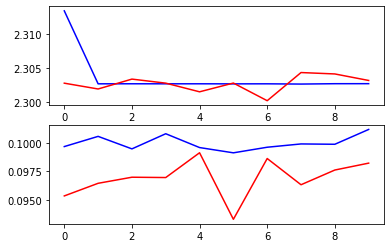

In [22]:
#Plot the training and valiation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [25]:
scores = model_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_1.predict(x_test)

10000/10000 [==============================] - 7s 703us/step
Test loss: 2.30262234954834
Test accuracy: 0.10000000149011612
